# Information Extraction

In [1]:
# Helper libraries
import warnings

# Scientific and visual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from emot import UNICODE_EMOJI, EMOTICONS_EMO
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from sklearn.preprocessing import MinMaxScaler

# Local Modules
from youtube_analysis.paths import TRANSFORMED_DATA_DIR
from youtube_analysis.cleanutils import translate_emojis, translate_emoticons
from youtube_analysis.edautils import plot_pie, plot_cat

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

In [2]:
corpus = pd.read_pickle(TRANSFORMED_DATA_DIR / "sentiment_corpus.pkl")

### Feature Extraction

In [3]:
def has_emojis(text):
    tokenized_text = word_tokenize(text)
    for emo in UNICODE_EMOJI:
        if emo in tokenized_text:
            return 1
    return 0


def has_emoticons(text):
    new_text = text
    for ticon in EMOTICONS_EMO:
        if ticon in new_text:
            return 1
    return 0

In [4]:
# For now we will only extract 2 simple features:
corpus["has_emojis"] = corpus.text.apply(lambda t: has_emojis(t))
corpus["has_emoticons"] = corpus.text.apply(lambda t: has_emoticons(t))

### Question Answering

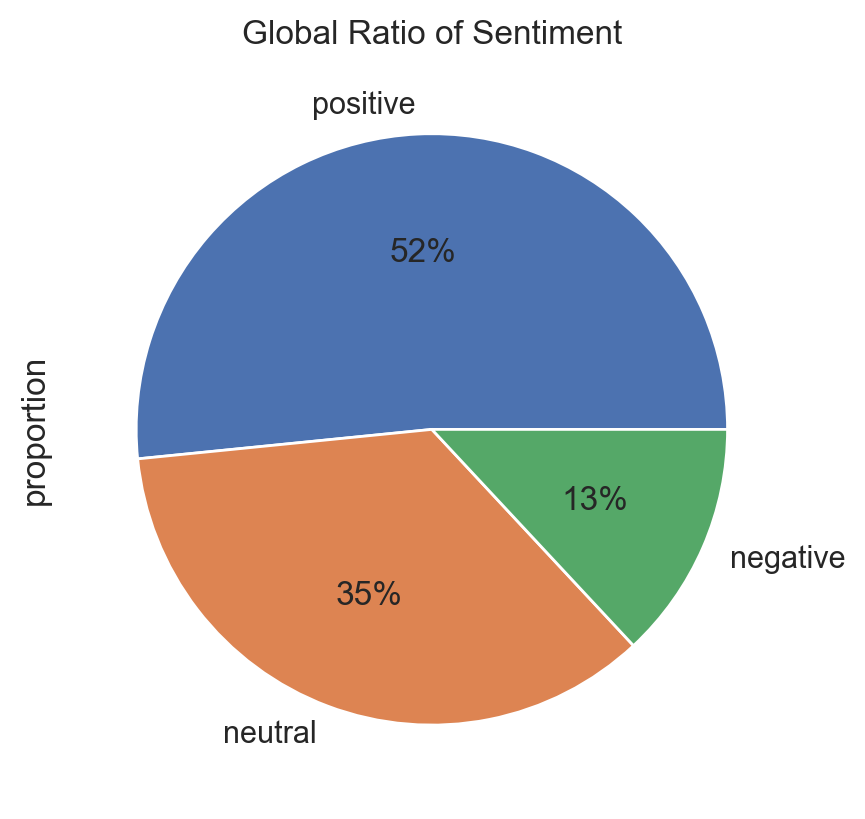

In [5]:
# What is the global sentiment ratio ?
plt.title("Global Ratio of Sentiment")
plot_pie(corpus, "sent_class")

In [6]:
# What is the relation between Likes and Sentiments ?

In [7]:
(corpus.groupby("sent_class")[["likes"]].agg(func=np.mean))

,likes
sent_class,
negative,0.3109
neutral,1.1203
positive,4.6607


In [8]:
corpus.groupby("sent_class").describe()[[("likes", "min"), ("likes", "max")]]

likes       
             min    max
sent_class             
negative     0.0    3.0
neutral      0.0  303.0
positive     0.0  370.0

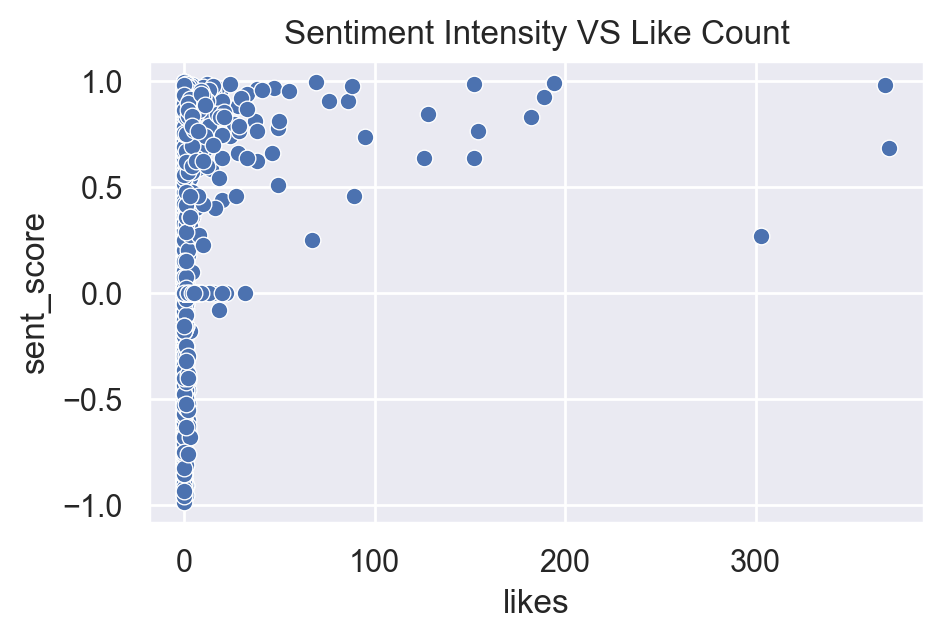

In [9]:
plt.figure(figsize=(5, 3))
plt.title("Sentiment Intensity VS Like Count")
sns.scatterplot(data=corpus, x="likes", y="sent_score")
plt.show()

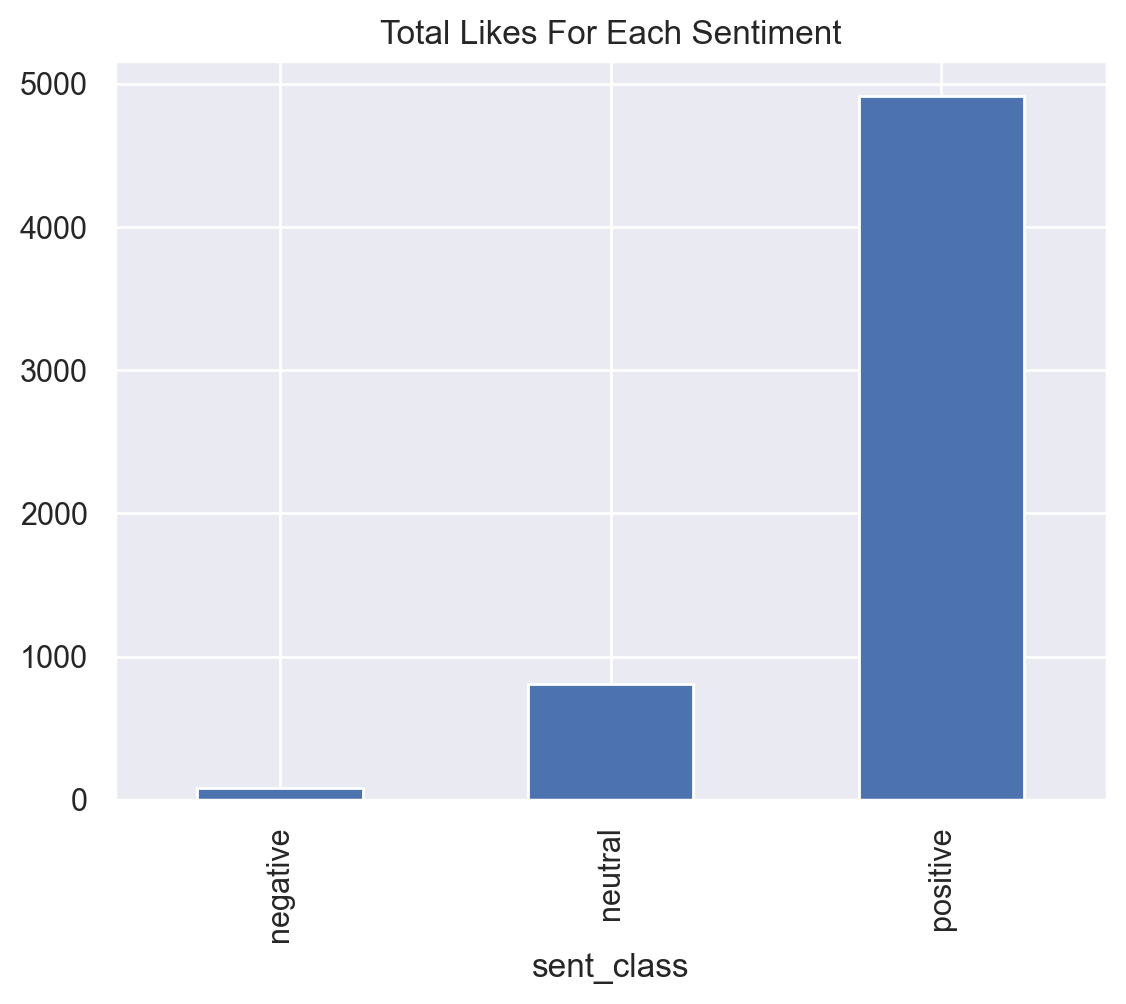

In [10]:
plt.title("Total Likes For Each Sentiment")
corpus.groupby("sent_class")["likes"].sum().plot.bar()
plt.show()

In [11]:
# How many comments contain "thank" and how are their sentiments ? ?
corpus.cleaned_text.str.contains("thank").sum()

169

In [12]:
thank_index = [i for i, v in enumerate(corpus.cleaned_text.str.contains("thank")) if v]
thank_corpus = corpus.iloc[thank_index]

In [13]:
np.round(thank_corpus.sent_class.value_counts(normalize=True), 1)

sent_class
positive    0.9
neutral     0.1
negative    0.0
Name: proportion, dtype: float64

In [14]:
# What is the ratio of people using emojis/emoticons
# and of those who don't?

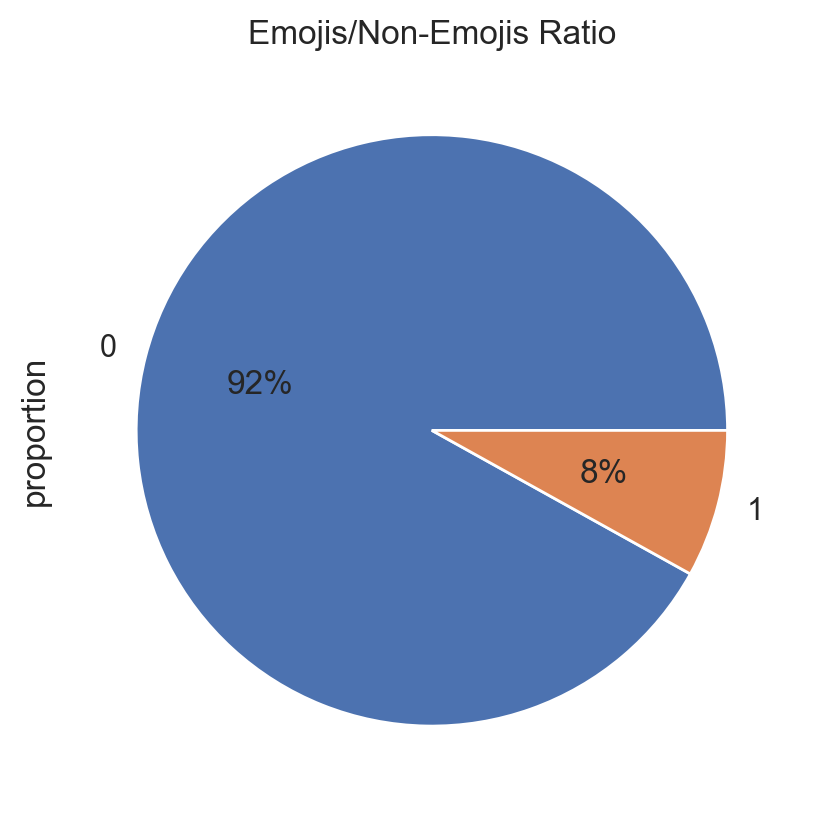

In [15]:
plt.title("Emojis/Non-Emojis Ratio")
plot_pie(corpus, "has_emojis")

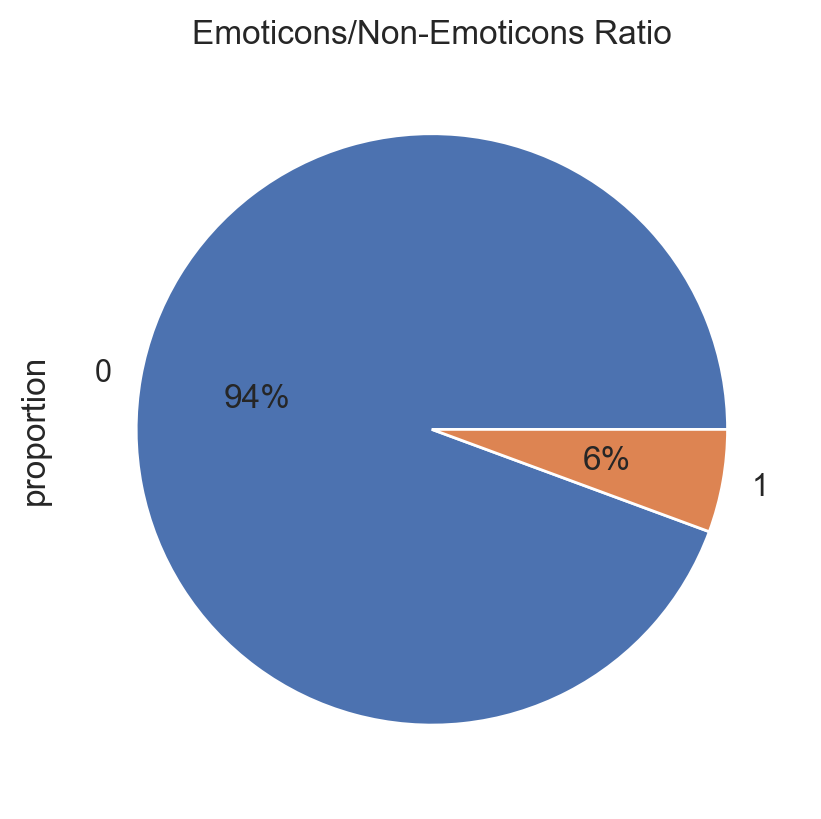

In [16]:
plt.title("Emoticons/Non-Emoticons Ratio")
plot_pie(corpus, "has_emoticons")

In [17]:
# What are the relations between emojis/emoticons and likes ?

In [18]:
corpus.groupby(["has_emojis"])[["likes"]].mean()

,likes
has_emojis,
0,3.0128
1,0.8848


In [19]:
# Emoticons are more like-prone than Emojis
corpus.groupby(['has_emoticons'])[['likes']].mean()

,likes
has_emoticons,
0,2.5870
1,7.1043


In [20]:
# What are the relations between emojis/emoticons and sentiments ?

In [21]:
pd.crosstab(corpus.sent_class, corpus.has_emojis)

has_emojis,0,1
sent_class,,
negative,258,9
neutral,672,51
positive,950,105


In [22]:
# How are emoticons in sentiments:
pd.crosstab(corpus.sent_class, corpus.has_emoticons)

has_emoticons,0,1
sent_class,,
negative,259,8
neutral,689,34
positive,982,73


In [23]:
# Who is the top commenter and what is its majority sentiment ?
# Given that some viewers comment several times.

In [24]:
corpus.author.describe()

count          2045
unique         1700
top       Dave Pyne
freq             16
Name: author, dtype: object

In [36]:
corpus.author.describe()["top"]

'Dave Pyne'

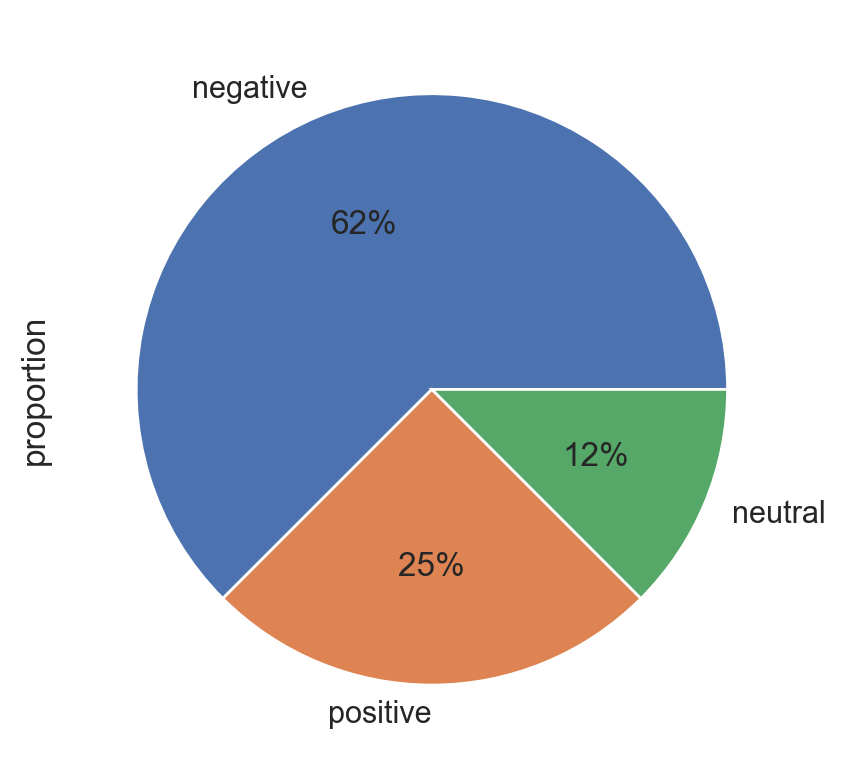

In [25]:
top_commenter = corpus[corpus.author=="Dave Pyne"]
plot_pie(top_commenter, "sent_class")

In [26]:
# What is he saying that is negative?
for text in top_commenter[top_commenter.sent_class=="negative"].text:
    print(text)
    print("-----------------------------------------------")

I think the moon is made of green cheese. You think there are aliens. I have been proven wrong. Have you been proven right? Doubtful.
-----------------------------------------------
The road to hell is paved with good intentions.
-----------------------------------------------
The fear of suffering is not the same as actually suffering and your no fear, may mean actual suffering for others.
-----------------------------------------------
You have seen nothing of atrocities like you will see, and the young people of today are running headlong into atrocities in the attempt to prove themselves better than our elders. Go woke, go broke, go dead.
-----------------------------------------------
I'll wait another 10000 years for humans to choose a way to live, that doesn't involve violence, because it will be a lot less time than you will take to seed a planet, we can never get to or communicate with to see if you are right. Don't get me wrong, I think you are brilliant, but very, very impra

In [27]:
# What are the most important topics of the top 3 commenters regarding likes?
corpus.sort_values(by="likes", ascending=False).head(3)

,author,published_at,updated_at,likes,text,cleaned_text,filtered_text,lemmatized_text,sent_class,sent_score,has_emojis,has_emoticons
1329,Julian Lineham,2022-12-31 15:12:30+00:00,2022-12-31 15:12:30+00:00,370,"Every interview is amazing, but this...",every interview is amazing but thi...,every interview amazing conversation...,every interview amazing conversation...,positive,0.6858,0,0
1968,Ulysses,2022-12-29 18:54:06+00:00,2022-12-29 18:54:06+00:00,368,As a Turkish and someone who has bee...,as a turkish and someone who has bee...,turkish someone following channel qu...,turkish someone following channel qu...,positive,0.9820,0,0
2002,No One,2022-12-29 18:03:32+00:00,2022-12-29 18:03:32+00:00,303,Lex taking himself less seriously wi...,lex taking himself less seriously wi...,lex taking less seriously podcast like,lex taking le seriously podcast like,neutral,0.2716,0,0


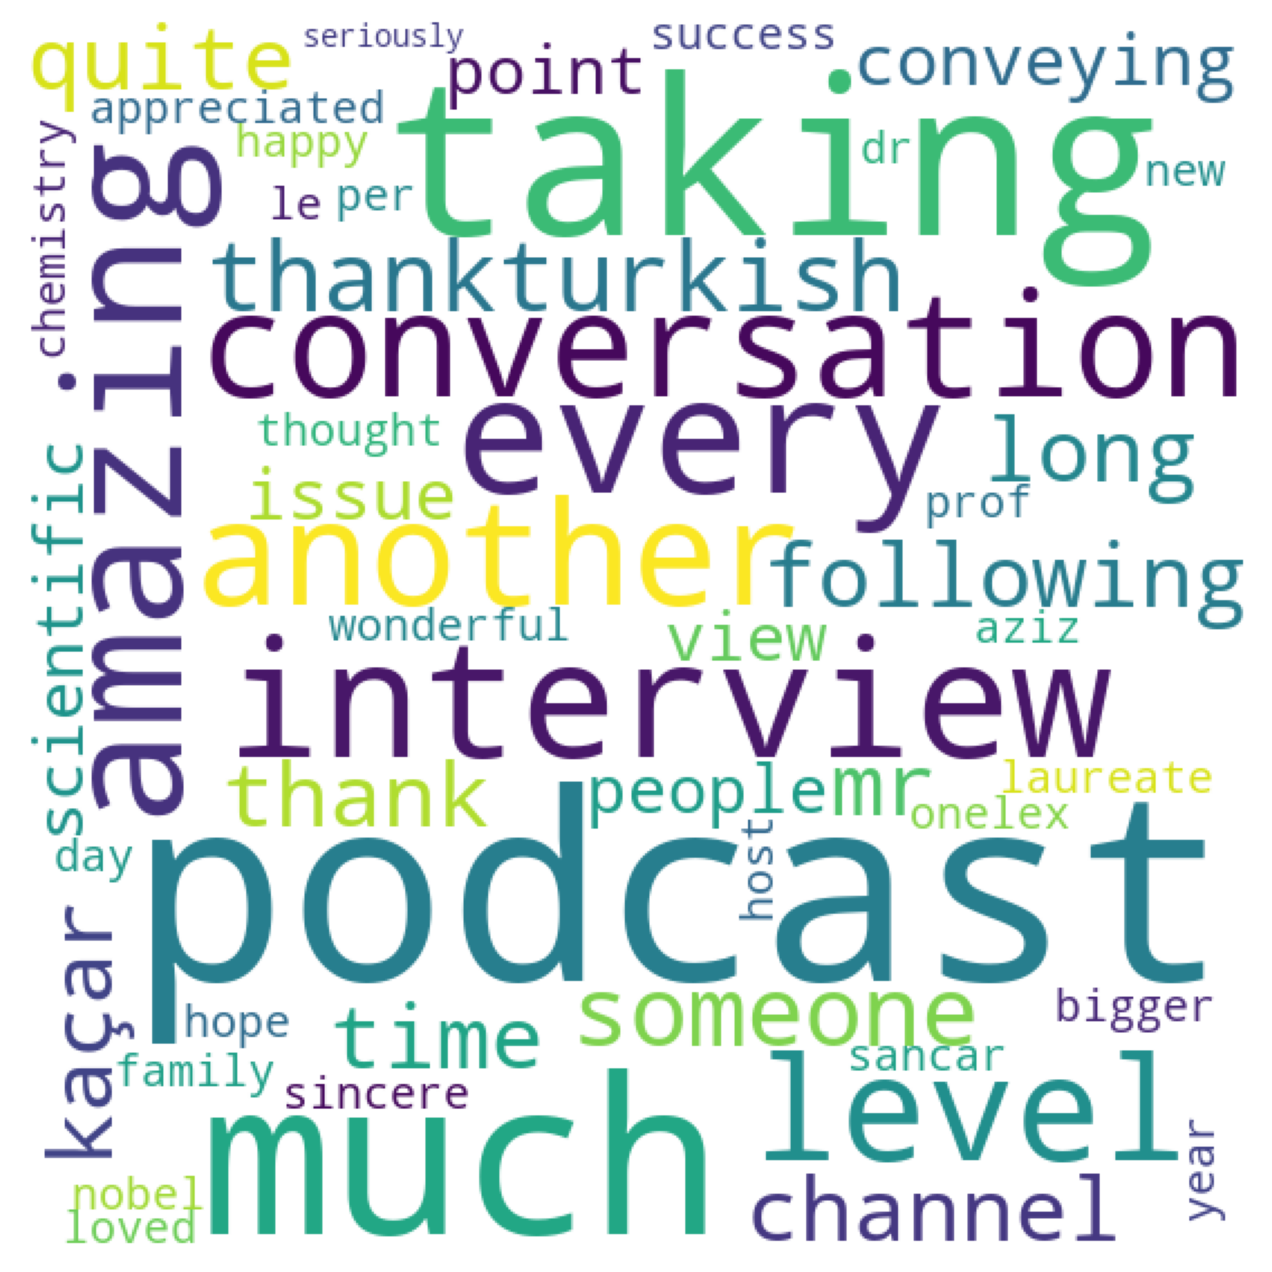

In [28]:
top_3_commenters_content = (
    corpus.sort_values(by="likes", ascending=False).head(3).lemmatized_text
)
top_terms = "".join([item for item in top_3_commenters_content])
stopword_list = set(STOPWORDS)

word_cloud = WordCloud(
    width=550,
    height=550,
    background_color="white",
    stopwords=stopword_list,
    min_font_size=10,
).generate(top_terms)

plt.figure(figsize=(10, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [29]:
# The same for negative sentiment class?

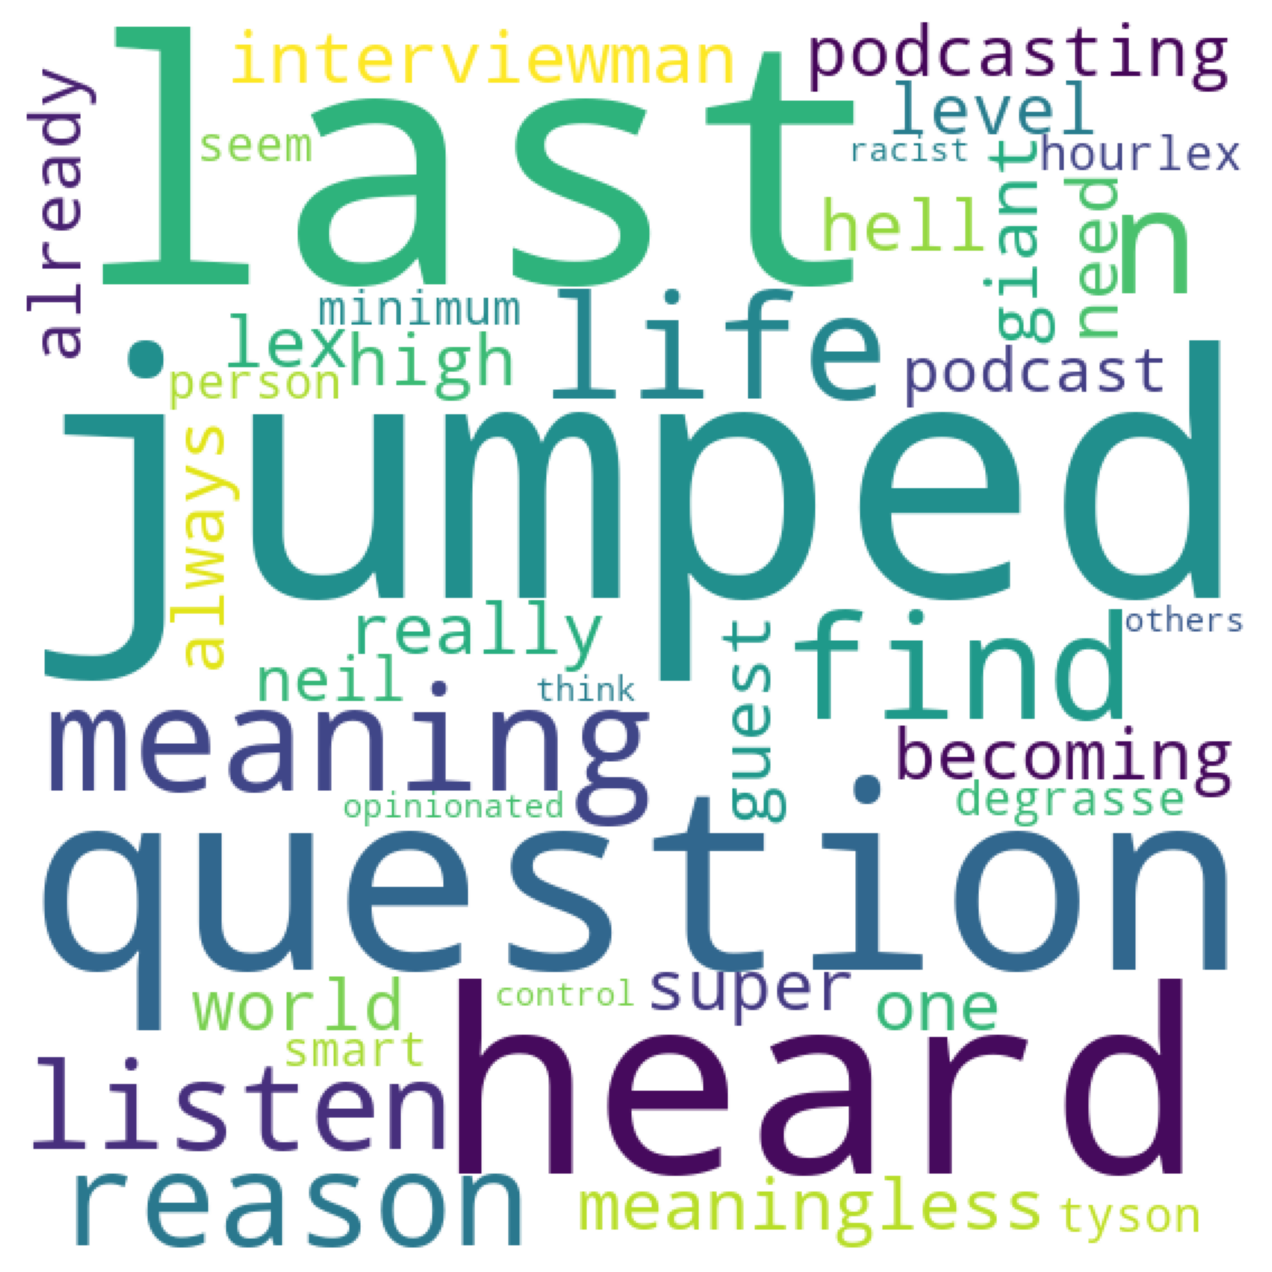

In [30]:
neg_top_3_commenters = (
    corpus[corpus.sent_class == "negative"]
    .sort_values(by="likes", ascending=False)
    .head(3)
    .lemmatized_text
)
top_terms = "".join([item for item in neg_top_3_commenters])

word_cloud = WordCloud(
    width=550,
    height=550,
    background_color="white",
    stopwords=stopword_list,
    min_font_size=10,
).generate(top_terms)

plt.figure(figsize=(10, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [31]:
# How Engagement run over time?

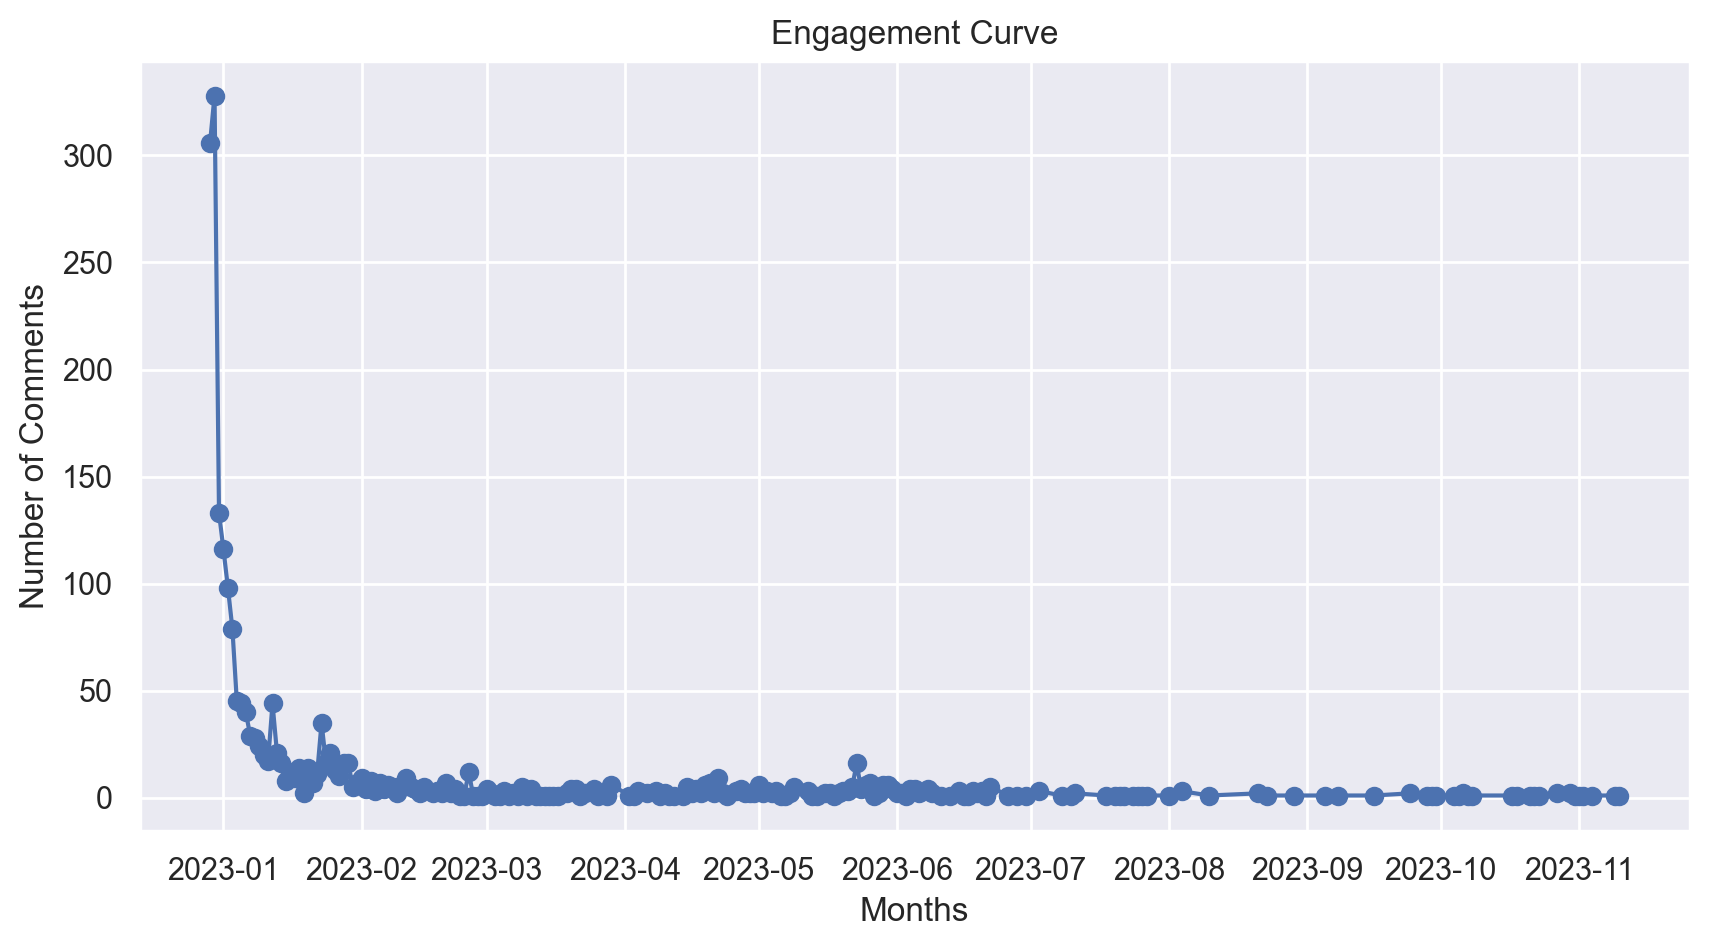

In [32]:
n_comments_over_time = corpus.groupby(corpus["published_at"].dt.date).size()

plt.figure(figsize=(10, 5))
plt.plot(
    n_comments_over_time.index,
    n_comments_over_time.values,
    marker="o",
    linestyle="-",
    color="b",
)
plt.title("Engagement Curve")
plt.xlabel("Months")
plt.ylabel("Number of Comments")
plt.grid(True)
plt.show()

In [38]:
# Number of Likes and Comments

n_comments_over_time = corpus.groupby(corpus["published_at"].dt.date).agg({'likes': 'sum', 'published_at': 'size'})

In [34]:
# Normalized Version
scaler = MinMaxScaler()
normalized_comments_over_time = n_comments_over_time.copy()
normalized_comments_over_time[["published_at","likes"]] = scaler.fit_transform(normalized_comments_over_time)

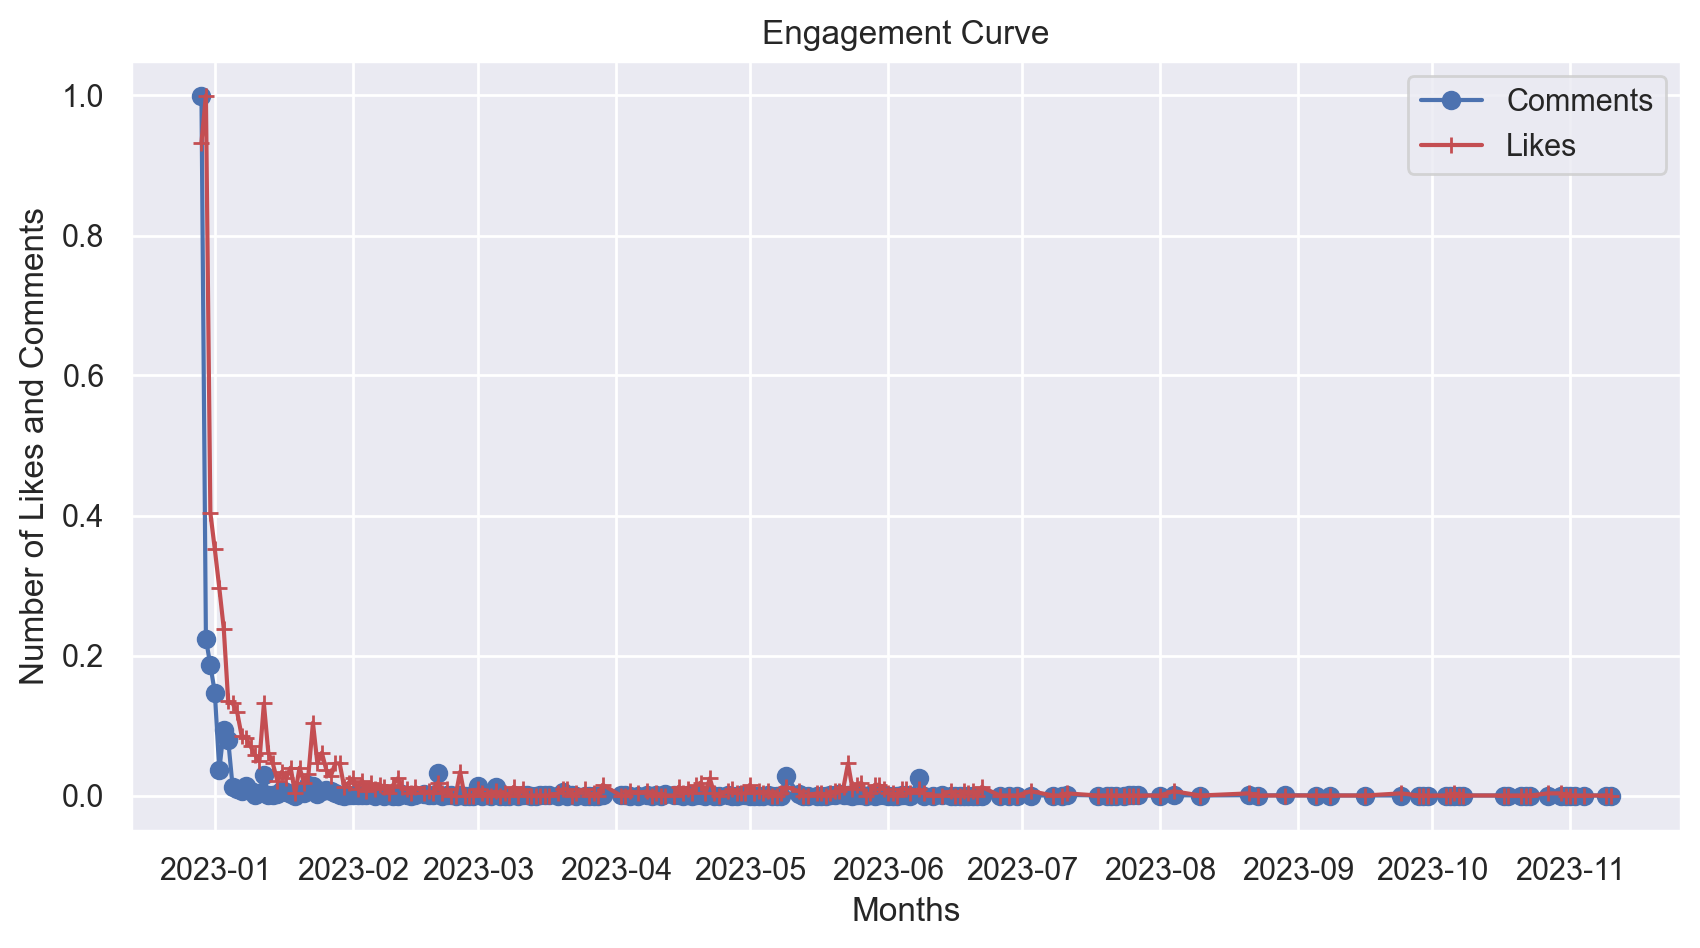

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(
    normalized_comments_over_time.index,
    normalized_comments_over_time.published_at,
    marker="o",
    linestyle="-",
    color="b",
    label="Comments",
)
plt.plot(
    normalized_comments_over_time.index,
    normalized_comments_over_time.likes,
    marker="+",
    linestyle="-",
    color="r",
    label="Likes",
)
plt.title("Engagement Curve")
plt.xlabel("Months")
plt.ylabel("Number of Likes and Comments")
plt.legend()
plt.grid(True)
plt.show()